# Optimization and linear algebra

Topics: Linear algebra, functions, optimization, Unicode support, pass by reference, arrays, types

## Example: Least squares

We will write a simple linear regression routine that will use linear algebra functions.

In [1]:
# load packages we will be using
using LinearAlgebra, DataFrames, CSV, GLM, BenchmarkTools

┌ Info: Recompiling stale cache file /Users/sen/.julia/compiled/v1.2/GLM/6OREG.ji for GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1240


We download the Arabidopsis data from the web URL.

In [2]:
agrenURL = "https://bitbucket.org/linen/smalldata/raw/3c9bcd603b67a16d02c5dc23e7e3e637758d4d5f/arabidopsis/agren2013.csv"
agren = CSV.read(download(agrenURL),missingstring="NA");

For convenience we subset the data to those without any missing data.  We will also convert the data frame into a matrix so that the linear regression routine does not have to handle missing data.

In [3]:
# drop the rows with missing data
agren1 = dropmissing(agren)
# check how many rows are left
nrow(agren1)

392

Next, we conver the data into a matrix (from a data frame); we will do the linear regression of fitness in Italy for 2010 using the 2009 data as the predictor.

In [4]:
# convert data frame to matrix
agrenMat = convert(Matrix,agren1[:,1:6])
# convert outcome/response vector to a matrix with one column
y = reshape(agrenMat[:,2],:,1)
# make the predictor matrix including an intercept
X = [ ones(nrow(agren1)) agrenMat[:,1] ]

392×2 Array{Float64,2}:
 1.0  19.7616 
 1.0   6.28846
 1.0  12.034  
 1.0  20.1253 
 1.0  15.1278 
 1.0  19.2091 
 1.0  12.9434 
 1.0  14.2244 
 1.0  20.5921 
 1.0  15.6141 
 1.0  10.9073 
 1.0  11.8156 
 1.0  13.0657 
 ⋮            
 1.0  12.8839 
 1.0  10.4514 
 1.0  12.6483 
 1.0   9.6031 
 1.0   9.4072 
 1.0  15.6564 
 1.0   8.98307
 1.0  12.1569 
 1.0   9.39266
 1.0  11.965  
 1.0  11.593  
 1.0  14.265  

We use the standard function to do the linear regression.

In [5]:
# run linear regression using built-in function
# @btime
out = lm(@formula(it10~it09),agren1)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

it10 ~ 1 + it09

Coefficients:
─────────────────────────────────────────────────────────────────────────────
              Estimate  Std. Error    t value  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.611065   0.660604   -0.925009    0.3555  -1.90985    0.687726
it09          0.708875   0.0530086  13.3728      <1e-33   0.604656   0.813093
─────────────────────────────────────────────────────────────────────────────

We will create a data structure called `Ls` to store the results of linear regression.

In [6]:
struct Ls
    β::Matrix{Float64} # regression coefficients
    V::Matrix{Float64} # variance covariance of estimates
end

Next we write a function to calculate the least squares estimate and variance-vovariance matrix.  Note that we specify the types of the arguments.  This is important for the compiler to optimize for speed.

In [7]:
function ls( y::Matrix{Float64}, X::Matrix{Float64} )
    n,p = size(X)   # dimensions of design matrix (predictors)
    β = (X'X)\(X'y) # least squares estimate
    yhat = X*β      # calculate fitted values
    σ = norm(y-yhat)/sqrt(n-p)  # calculate residual standard deviation
    return Ls(β,(σ^2*inv(X'X))) # return estimate and variance/covariance
end

ls (generic function with 1 method)

We now examine the estimates and compare with the values of the standard implementation.  Note that this simple implementation is actually faster.

In [8]:
# @btime
lsout = ls(y,X)

Ls([-0.6110646951084405; 0.7088745462882894], [0.4363973679891619 -0.03434349111923562; -0.03434349111923562 0.0028099070240469887])

In [9]:
hcat( lsout.β, coef(out) )

2×2 Array{Float64,2}:
 -0.611065  -0.611065
  0.708875   0.708875

We compare the variance covariances as well, which are also essentially identical.

In [10]:
lsout.V

2×2 Array{Float64,2}:
  0.436397   -0.0343435 
 -0.0343435   0.00280991

In [11]:
vcov(out)

2×2 Array{Float64,2}:
  0.436397   -0.0343435 
 -0.0343435   0.00280991

## Example: Gradient descent

Now we examine writing a simple minimizer using gradient descent for a convex function that is a squared error loss with a L$_1$ penalty.  We import a package to perform symbolic differentiation.

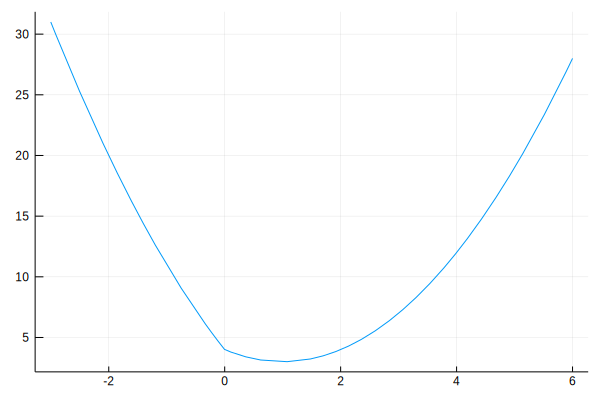

In [12]:
using Calculus, Plots
f(x) = (x-2.0)^2 + 2.0*abs(x)
plot(f,-3,6,lab="")

We calculate the derivative and assign the the function a name.

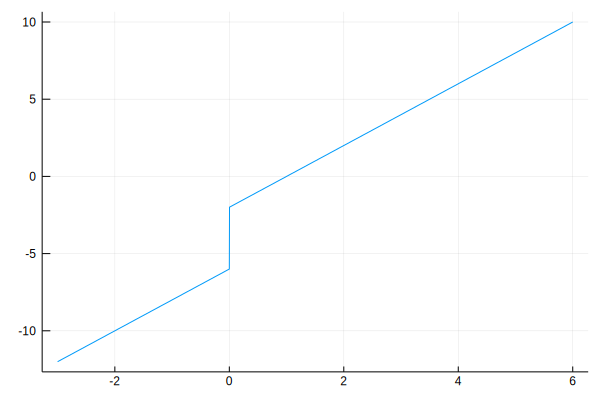

In [13]:
g = derivative(f)
plot(g,-3,6,lab="")

We write the gradient descent solver that takes as input the function, its gradient, an initial value, a stepsize, and a tolerance value to determine convergence.  The block of text within triple quotes before a function definition is interpreted as Markdown for documenting the function.

The function is very easy to understand, and almost looks like pseudocode.

In [14]:
"""
gradientDescent: Minimizer of a one-dimensional function using gradient descent

- f = function to minimize (scalar arguments)   
- Δf = derivative of f   
- x0 = starting value  
- stepsize = step size for gradient descent  
- tol = tolerance for determining convergence
"""
function gradientDescent( f::Function, Δf::Function, x0::Float64, stepsize::Float64, tol::Float64)
    change = 10.0*tol # initialize change variable
    x1 = x0 # intialize current value
    while( abs(change)>tol ) # repeat loop while convergence criterion unmet
        x1 = x0 - stepsize*Δf(x0) # new value is old value in the direction of the gradient
        change = f(x1)-f(x0) # calculate change
        x0 = x1 # update old value
    end
    return x1, f(x1) # return minimizer and function value
end

gradientDescent

In [15]:
?gradientDescent

search: gradientDescent



gradientDescent: Minimizer of a one-dimensional function using gradient descent

  * f = function to minimize (scalar arguments)
  * Δf = derivative of f
  * x0 = starting value
  * stepsize = step size for gradient descent
  * tol = tolerance for determining convergence


Now we are ready to apply this function to the LASSO like function.

In [16]:
gradientDescent( f , g, 1.0, 0.5, 1e-5)

(1.0, 3.0)

In [17]:
f(0)

4.0

## Pass by reference

When dealing with large datasets, it is useful to avoid copying the data too much.  In Julia, arrays are passed by reference, by default.  This may take some getting used to for R or Matlab users, as the following example shows.

We define an array with three values.

In [18]:
men = ["tom","dick","harry"]

3-element Array{String,1}:
 "tom"  
 "dick" 
 "harry"

We make a copy called `horsemen`, which is just a copy of the pointer, so is still referring to the same data as `men`.

The variable `footment` holds a copy of the data into a new array.

In [19]:
horsemen = men
footmen = copy(men)
hcat( men, horsemen, footmen )

3×3 Array{String,2}:
 "tom"    "tom"    "tom"  
 "dick"   "dick"   "dick" 
 "harry"  "harry"  "harry"

Not let's change the name of the first element of `men`, and see what happens.

In [20]:
horsemen[1] = "john"
hcat(men,horsemen,footmen)

3×3 Array{String,2}:
 "john"   "john"   "tom"  
 "dick"   "dick"   "dick" 
 "harry"  "harry"  "harry"

We see that both `men` and `horsemen` have changed, but `footmen` has not (because it is a copy of the original data).

Not copying data saves a lot of time, as the following timing example shows.

In [21]:
@time x0 = randn(10000,10000);

  1.413381 seconds (81.03 k allocations: 767.153 MiB, 2.22% gc time)


In [22]:
@time x1 = x0; # copy pointer

  0.000002 seconds (5 allocations: 208 bytes)


In [23]:
@time x2 = copy(x0); # copy data

  0.718675 seconds (34 allocations: 762.942 MiB, 22.02% gc time)
